### What this code does

What this does

Extract: Simulates an API response with a Python list of dictionaries.

Transform:

Handles nested fields (weather, sys, wind, main)

Fills missing data (e.g., wind for New York)

Converts timestamps

Adds new computed columns (wind_speed_kmh, extracted_at)

Load: Saves the cleaned DataFrame to a SQLite database.

In [ ]:
import pandas as pd
from sqlalchemy import create_engine # For database connection 
from datetime import datetime


# 1. Extract: Simulated API response and store in variable
# Sample JSON data simulating API response
# the weather sample API is already list --> so we use item.get
sample_api_response = [
    {
        "name": "Bangkok",
        "sys": {"country": "TH"},
        "weather": [{"main": "Clouds", "description": "scattered clouds"}],
        "main": {"temp": 31.2, "feels_like": 33.0, "humidity": 70, "pressure": 1008},
        "wind": {"speed": 3.5},
        "clouds": {"all": 40},
        "dt": 1694937600
    },
    {
        "name": "London",
        "sys": {"country": "GB"},
        "weather": [{"main": "Rain", "description": "light rain"}],
        "main": {"temp": 18.5, "feels_like": 17.8, "humidity": 80, "pressure": 1012},
        "wind": {"speed": 5.0},
        "clouds": {"all": 90},
        "dt": 1694937600
    },
    {
        "name": "New York",
        "sys": {"country": "US"},
        "weather": [{"main": "Clear", "description": "clear sky"}],
        "main": {"temp": 22.0, "feels_like": 21.5, "humidity": 60, "pressure": 1015},
        "wind": {},  # simulate missing wind data
        "clouds": {"all": 5},
        "dt": 1694937600
    }
]


# 2. Transform: Convert JSON to Pandas DataFrame

records = []
for item in sample_api_response:
    record = {
        "city": item.get("name"),
        "country": item.get("sys", {}).get("country"),
        # checks if weather key exists, this takes the first element ([0]). If missing or empty, the whole expression returns None
        "weather_main": item.get("weather")[0]["main"] if item.get("weather") else None, 
        "weather_desc": item.get("weather")[0]["description"] if item.get("weather") else None,
        # If "main" doesn’t exist, instead of raising an error, it returns an empty dictionary {} as the default.Next, get the temp value but if "temp" is missing, it returns None.    
        "temp_c": item.get("main", {}).get("temp"),
        "feels_like_c": item.get("main", {}).get("feels_like"),
        "humidity": item.get("main", {}).get("humidity"),
        "pressure": item.get("main", {}).get("pressure"),
        "wind_speed_mps": item.get("wind", {}).get("speed", 0),  # default 0 if missing
        "clouds_percent": item.get("clouds", {}).get("all"),
        "data_calc_time": datetime.fromtimestamp(item.get("dt")) if item.get("dt") else None
    }
    records.append(record)
    print(record)  # Print each record for debugging

df = pd.DataFrame(records)

# Convert wind speed m/s → km/h
df["wind_speed_kmh"] = df["wind_speed_mps"] * 3.6

# Add extraction timestamp
df["extracted_at"] = datetime.now()

print("Transformed DataFrame:")
print(df)


# 3. Load: Save DataFrame to SQLite
engine = create_engine("sqlite:///weather_practice.db") # SQLite database file
df.to_sql("city_weather", con=engine, if_exists="replace", index=False) # Replace table if exists

print("Data loaded into DB successfully!")


{'city': 'Bangkok', 'country': 'TH', 'weather_main': 'Clouds', 'weather_desc': 'scattered clouds', 'temp_c': 31.2, 'feels_like_c': 33.0, 'humidity': 70, 'pressure': 1008, 'wind_speed_mps': 3.5, 'clouds_percent': 40, 'data_calc_time': datetime.datetime(2023, 9, 17, 14, 30)}
{'city': 'London', 'country': 'GB', 'weather_main': 'Rain', 'weather_desc': 'light rain', 'temp_c': 18.5, 'feels_like_c': 17.8, 'humidity': 80, 'pressure': 1012, 'wind_speed_mps': 5.0, 'clouds_percent': 90, 'data_calc_time': datetime.datetime(2023, 9, 17, 14, 30)}
{'city': 'New York', 'country': 'US', 'weather_main': 'Clear', 'weather_desc': 'clear sky', 'temp_c': 22.0, 'feels_like_c': 21.5, 'humidity': 60, 'pressure': 1015, 'wind_speed_mps': 0, 'clouds_percent': 5, 'data_calc_time': datetime.datetime(2023, 9, 17, 14, 30)}
Transformed DataFrame:
       city country weather_main      weather_desc  temp_c  feels_like_c  \
0   Bangkok      TH       Clouds  scattered clouds    31.2          33.0   
1    London      GB   

#### Automatically Update Rows Instead of Appending Duplicates

Right now, df.to_sql(..., if_exists="append") always adds new rows. To avoid duplicates using city + data_calc_time as a unique key:

Approach:

Create the SQLite table with a composite primary key.

Use INSERT OR REPLACE to update existing rows.

In [ ]:
import sqlite3

# Connect to SQLite
conn = sqlite3.connect("weather_practice.db")
cur = conn.cursor()

# Create table with composite primary key
cur.execute("""
CREATE TABLE IF NOT EXISTS city_weather (
    city TEXT,
    country TEXT,
    weather_main TEXT,
    weather_desc TEXT,
    temp_c REAL,
    feels_like_c REAL,
    humidity INTEGER,
    pressure INTEGER,
    wind_speed_mps REAL,
    clouds_percent INTEGER,
    wind_speed_kmh REAL,
    data_calc_time TIMESTAMP,
    extracted_at TIMESTAMP,
    PRIMARY KEY (city, data_calc_time)
)
""")
conn.commit()

# Insert data using "INSERT OR REPLACE"
# and handle potential errors by skipping problematic rows

try:
    # (index, row)here, they wrote _ instead of index.In Python, _ is a throwaway variable (it means “I don’t care about this value”).
    for _, row in df.iterrows(): 
        try:
            cur.execute("""
            INSERT OR REPLACE INTO city_weather (
                city, country, weather_main, weather_desc, temp_c, feels_like_c,
                humidity, pressure, wind_speed_mps, clouds_percent, wind_speed_kmh,
                data_calc_time, extracted_at
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (
                row.city,
                row.country,
                row.weather_main,
                row.weather_desc,
                row.temp_c,
                row.feels_like_c,
                row.humidity,
                row.pressure,
                row.wind_speed_mps,
                row.clouds_percent,
                row.wind_speed_kmh,
                # hasattr(obj, "method") checks whether the object has a certain attribute/method.
                row.data_calc_time.to_pydatetime() if hasattr(row.data_calc_time, "to_pydatetime") else row.data_calc_time,
                row.extracted_at.to_pydatetime() if hasattr(row.extracted_at, "to_pydatetime") else row.extracted_at
            ))
        except Exception as e_row:
            print(f"Skipping row for city {row.city} due to error: {e_row}")

    conn.commit()
    print("All valid rows inserted successfully!")

except Exception as e:
    print(f"Database operation failed: {e}")

finally:
    conn.close()
    print("Database connection closed.")


All valid rows inserted successfully!
Database connection closed.


Case 1: Pandas Timestamp

ts = pd.Timestamp("2023-09-17 12:30:00")

print(ts.to_pydatetime())  # datetime.datetime(2023, 9, 17, 12, 30)

Case 2: Python datetime

dt = datetime(2023, 9, 17, 12, 30)

print(hasattr(dt, "to_pydatetime"))  # False

So in the loop:

If the row has a Timestamp → convert it.

If the row already has a datetime → keep it.

If it’s None → keep it.

This matters because some libraries (like SQLite, Postgres, or JSON encoders) only accept real Python datetime objects, not Pandas Timestamp.

#### Visualize Temperature Trends or Weather Conditions
Quick way to check your ETL results visually.

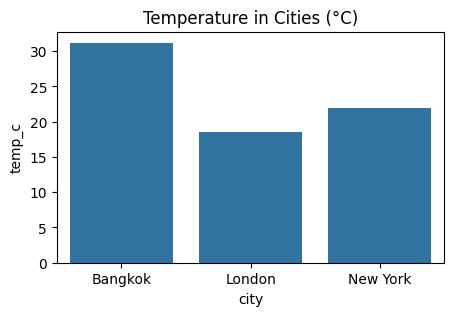

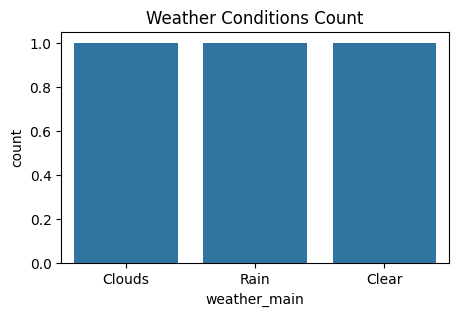

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Temperature trends
plt.figure(figsize=(5,3))
sns.barplot(data=df, x='city', y='temp_c')
plt.title("Temperature in Cities (°C)")
plt.show()

# Weather condition counts
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='weather_main')
plt.title("Weather Conditions Count")
plt.show()


### Optional Enhancements

Automatically update rows instead of appending duplicates using city + data_calc_time as a primary key.

Schedule daily ETL with Airflow or cron.

Visualize temperature trends or weather conditions with Matplotlib/Seaborn.

Include error handling for missing fields or unexpected JSON structure.

#### Airflow (more professional)

Define an example DAG that runs daily:

In [ ]:
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime, timedelta

def etl_task():
    import pandas as pd
    # put your ETL code here
    print("ETL executed!")

dag = DAG(
    'daily_weather_etl',
    start_date=datetime(2025, 1, 1),
    schedule_interval='0 9 * * *',  # daily 9 AM
    catchup=False
)

task = PythonOperator(
    task_id='run_weather_etl',
    python_callable=etl_task,
    dag=dag
)
